In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
path2target = '/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/atom6750/model_18/0deg_100eV'
# path2target = '/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/atom16000/model_18/0deg_1000eV'

insert_atom_every_timestep = 20000
width = 4.0725 # nm
# width = 5.43 # nm
area = width**2

# number of injection to take average over
num_injection = 15

In [3]:
def get_sp_yield_and_ion_dose_df(path2target, insert_atom_every_timestep=20000, area=4.0725**2, num_injection=15):
    with open(os.path.join(path2target, 'etch.dat'), mode='r') as f:
        lines = [s.strip() for s in f.readlines()]

    idx_list = []
    for i, l in enumerate(lines):
        if 'ITEM: TIMESTEP' in l:
            idx_list.append(i)

    idx_list_shift = idx_list[1:]
    idx_list_shift.append(len(lines))

    block = []
    for idx1, idx2 in zip(idx_list, idx_list_shift):
        block.append(lines[idx1:idx2])

    result = []
    timestep_idx = 1
    num_sputter_atom_idx = 3
    for b in block:
        timestep = int(b[timestep_idx])
        num_sputter_atom = int(b[num_sputter_atom_idx])
        result.append(np.array([timestep, num_sputter_atom]))

    sp_df = pd.DataFrame(result, columns=['timestep', 'num_sputter_atom'])

    def get_num_inserted_atom(timestep, insert_atom_every_timestep):
        return (timestep // insert_atom_every_timestep) + 1

    def get_ion_dose(area, timestep, insert_atom_every_timestep):
        return get_num_inserted_atom(timestep, insert_atom_every_timestep) / area

    sp_df['num_inserted_atoms'] = sp_df['timestep'].apply(lambda x: get_num_inserted_atom(x, insert_atom_every_timestep))
    sp_df['ion_dose'] = sp_df['timestep'].apply(lambda x: get_ion_dose(area, x, insert_atom_every_timestep))

    max_num_inserted_atoms = sp_df['num_inserted_atoms'].max()

    sp_df_injection = sp_df.drop_duplicates(subset=['timestep'])
    sp_df_injection = sp_df_injection.query('timestep % @insert_atom_every_timestep == 0').copy()

    # get average number of sputtered atoms
    def get_averaged_num_sputtered_atoms(num_inserted_atoms, num_injection):
        lower = num_inserted_atoms - num_injection if num_inserted_atoms - num_injection > 0 else 0
        upper = num_inserted_atoms + num_injection if num_inserted_atoms + num_injection < max_num_inserted_atoms else max_num_inserted_atoms
        return sp_df.query('num_inserted_atoms >= @lower and num_inserted_atoms <= @upper')['num_sputter_atom'].sum() / (upper - lower + 1)

    sp_df_injection['num_sputter_atom_avg'] = sp_df_injection['num_inserted_atoms'].apply(lambda x: get_averaged_num_sputtered_atoms(x, num_injection))

    return sp_df_injection

In [9]:
sp_df_injection = get_sp_yield_and_ion_dose_df(path2target)
sp_df_injection['injection_energy'] = path2target.split('/')[-1].split('_')[-1][:-2]

In [4]:
# all_path = [
#     ["/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/atom6750/model_18/0deg_100eV", 4.0725**2],
#     ["/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/atom6750/model_18/0deg_200eV", 4.0725**2],
#     ["/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/atom6750/model_18/0deg_500eV", 4.0725**2],
#     ["/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/atom6750/model_18/0deg_750eV", 4.0725**2],
#     ["/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/atom16000/model_18/0deg_1000eV", 5.43**2],
# ]
all_path = [
    ["/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/depth15/0deg_1000eV", 4.0725**2, 'width_4.075-height_8.145'],
    ["/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/atom6750/model_18/0deg_1000eV", 4.0725**2, 'width_5.43-height_10.86'],
    ["/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/atom16000/model_18/0deg_1000eV", 5.43**2, 'width_4.075-height_13.575'],
]

In [43]:
all_sp_df_injection = []
for path, area in all_path:
    sp_df_injection = get_sp_yield_and_ion_dose_df(path, area=area)
    sp_df_injection['injection_energy'] = path.split('/')[-1].split('_')[-1][:-2]
    all_sp_df_injection.append(sp_df_injection)

all_sp_df_injection = pd.concat(all_sp_df_injection)

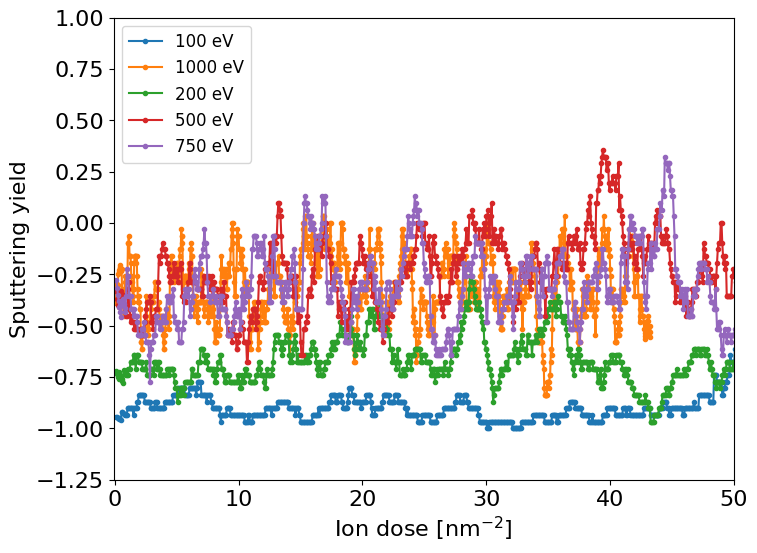

In [55]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for injection_energy, df in all_sp_df_injection.groupby('injection_energy'):
    ax.plot(df['ion_dose'], df['num_sputter_atom_avg']-1, marker='.', label=f'{injection_energy} eV')

ax.set_xlabel('Ion dose [nm$^{-2}$]', fontsize=16)
ax.set_ylabel('Sputtering yield', fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlim(-.1, 50)
ax.set_ylim(-1.25, 1.0)
ax.legend(fontsize=12)

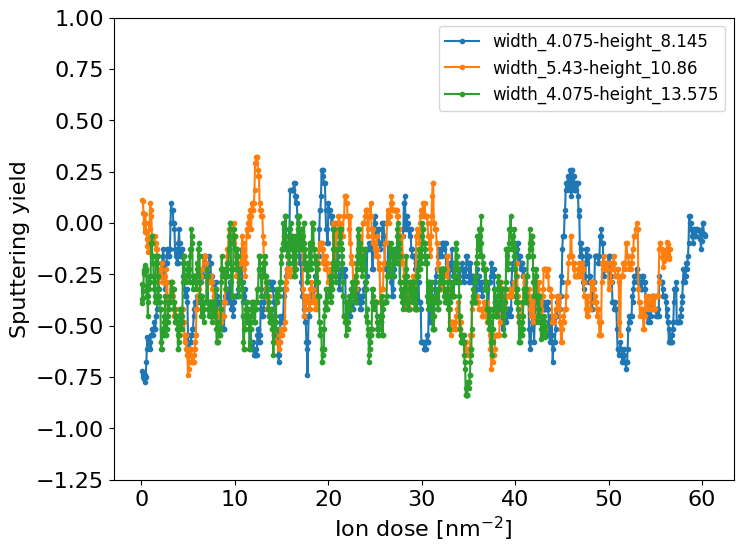

In [6]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for path, area, label in all_path:
    sp_df_injection = get_sp_yield_and_ion_dose_df(path, area=area)

    ax.plot(sp_df_injection['ion_dose'], sp_df_injection['num_sputter_atom_avg']-1, marker='.', label=label)

ax.set_xlabel('Ion dose [nm$^{-2}$]', fontsize=16)
ax.set_ylabel('Sputtering yield', fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
# ax.set_xlim(-.1, 50)
ax.set_ylim(-1.25, 1.0)
ax.legend(fontsize=12)